# Formal concept analysis

We apply FCA to Wikivitals to find relevant set of words (= concepts) shared by groups of articles.

## Import

In [1]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from pulp import *
from scipy import sparse

In [2]:
from sknetwork.data import load_netset
from sknetwork.utils import get_degrees, get_membership
from sknetwork.ranking import top_k

In [75]:
# Plot degree distribution
def plot_distrib(dict_values, ax, xlabel='degree', log=True, title=None, color='blue', alpha=1, label='Degree distribution'):
    #values = [v for k, v in dict_values.items()]
    #counter = Counter(values)
    x, y = zip(*dict_values.items())
    ax.scatter(x, y, marker='+', color=color, alpha=alpha, label=label)
    ax.legend()
    ax.set_title(title)
    if log and len(y) > 100:
        ax.set_xscale('log')
        ax.set_xlabel(xlabel + ' (log)')
    else:
        ax.set_xlabel(xlabel)
    ax.set_ylabel('Frequency' + ' (log)')
    ax.set_yscale('log')

## Data


In [3]:
wikivitals = load_netset('wikivitals')

Parsing files...
Done.


In [4]:
biadjacency = wikivitals.biadjacency
names = wikivitals.names
words = wikivitals.names_col
labels = wikivitals.labels

In [5]:
biadjacency

<10011x37845 sparse matrix of type '<class 'numpy.int64'>'
	with 1363301 stored elements in Compressed Sparse Row format>

In [6]:
print(names[0])
print(words[biadjacency[0].indices])

0
['from' 'historically' 'identity' 'system' 'zero' 'for' 'be' 'slang'
 'naught' 'integer' 'or' 'the' 'a' 'many' 'fulfill' 'in' 'numerical' 'to'
 'algebraic' 'use' 'least' 'well' 'role' 'context' 'and' 'that' 'where'
 'central' 'place' 'adjacent' 'informal' 'digit' 'term' 'US' 'UK' 'also'
 'of' 'as' 'o' 'name' 'represent' 'English' 'zip' 'placeholder' 'one'
 'letter' 'value' 'mathematic' 'additive' 'structure' 'cipher' 'have'
 'include' 'it' 'ought' 'at' 'real' 'number' 'numeral' 'distinguish'
 'other']


## FCA

In [7]:
context = biadjacency > 0

In [8]:
context

<10011x37845 sparse matrix of type '<class 'numpy.bool_'>'
	with 1363301 stored elements in Compressed Sparse Row format>

In [9]:
def get_concepts(context, n_concepts = 5000, n_objects_max = 1000, n_objects_min = 10, depth = 5):
    """Get concepts by FCA.
    
    Parameters
    ----------
    context : sparse matrix
        Matrix object x attribute.
    n_concepts : int
        Maximum number of concepts per level (except top level).
    n_objects_max : int
        Maximum number of objects per attribute (frequent attributes are discarded).
    n_objects_min : int
        Minimum number of objects per attribute (rare attributes are discarded).
    depth : int
        Depth of the hierarchy
        
    Returns
    -------
    index_attribute : np.ndarray
        Index of attributes.
    concept_attribute : sparse matrix
        Matrix concept x attributes.
    concept_object : sparse matrix
        Matrix concept x object.
    """
    n_objects, n_attributes = context.shape

    # select attributes
    freq_attribute = get_degrees(context, transpose=True)
    index = np.flatnonzero((freq_attribute <= n_objects_max) & (freq_attribute >= n_objects_min))
    attribute = sparse.identity(n_attributes).tocsr()[index]
    n_attributes = len(index)
    concept_attribute = sparse.identity(n_attributes).tocsr()
    concept_object = context.T.tocsr()[index]
    freq_attribute = freq_attribute[index]
    index_attribute = index.copy()
    
    # simple concepts (= single attribute)
    simple_concept_attribute = concept_attribute.copy()
    simple_concept_object = concept_object.copy()
    simple_concept_freq = freq_attribute.copy()

    # current concepts (= simple concepts to start)
    current_concept_attribute = concept_attribute.copy()
    current_concept_object = concept_object.copy()
    current_concept_freq = freq_attribute.copy()

    for t in range(1, depth):

        # add attribute
        concept_count = current_concept_object.astype(int).dot(simple_concept_object.T).tocoo()
        row = concept_count.row
        col = concept_count.col
        count = concept_count.data

        # score concepts
        scores = np.minimum(current_concept_freq[row] - count, simple_concept_freq[col] - count)
        scores = np.minimum(scores, count)
        scores = scores * (scores >= n_objects_min)

        # select concepts
        index = top_k(scores, n_concepts)
        concept_attribute_ = sparse.lil_matrix((n_concepts, n_attributes), dtype=bool)
        concept_ids = current_concept_attribute[row[index]].indices
        attribute_ids = simple_concept_attribute[col[index]].indices
        row_ = np.repeat(np.arange(len(index)), t + 1)
        col_ = np.hstack((concept_ids.reshape(-1, t), attribute_ids.reshape(-1, 1))).ravel()
        concept_attribute_[row_, col_] = 1
        concept_attribute_ = concept_attribute_.tocsr()

        # remove duplicates
        _, index_ = np.unique(concept_attribute_.indices.reshape(-1, t + 1), axis=0, return_index=True)
        concept_attribute_ = concept_attribute_[index_]
        index = index[index_]

        # count objects
        concept_object_ = current_concept_object[row[index]].minimum(simple_concept_object[col[index]])
        concept_object_.eliminate_zeros()
        concept_freq_ = get_degrees(concept_object_)

        # update 
        concept_attribute = sparse.vstack((concept_attribute, concept_attribute_))
        concept_object = sparse.vstack((concept_object, concept_object_))

        current_concept_attribute = concept_attribute_.copy()
        current_concept_object = concept_object_.copy()
        current_concept_freq = concept_freq_.copy()
    
    return index_attribute, concept_attribute, concept_object

In [10]:
%%time
index_attribute, concept_attribute, concept_object = get_concepts(context)

CPU times: user 2.06 s, sys: 532 ms, total: 2.6 s
Wall time: 2.64 s


In [11]:
names_attribute = words[index_attribute]

In [12]:
concept_object

<24348x10011 sparse matrix of type '<class 'numpy.bool_'>'
	with 1810724 stored elements in Compressed Sparse Row format>

In [13]:
concept_attribute

<24348x11250 sparse matrix of type '<class 'numpy.float64'>'
	with 60418 stored elements in Compressed Sparse Row format>

## Freq count

In [14]:
concept_freq = get_degrees(concept_object)

In [15]:
length_concept = get_degrees(concept_attribute)

In [16]:
lengths, counts = np.unique(length_concept, return_counts=True)

In [17]:
print(counts)

[11250  2525  2540  3667  4366]


In [18]:
depth = max(lengths)

In [19]:
concept_attribute

<24348x11250 sparse matrix of type '<class 'numpy.float64'>'
	with 60418 stored elements in Compressed Sparse Row format>

## Word2Vec method  

**Objective**: Take into account the semantic meaning of attributes in order to select interesting concepts; we want to filter concepts that have close semantic meanings, as they do not bring additional interesting information for the considered object.  

**Procedure**:  
1. Filter concepts that have size 1 exactly (to reduce memory usage for the next steps). These concepts are not specific enough  
2. Apply **w2v** model to compute **word embeddings**. We compute embedding in $\mathbb{R}^{100}$  
3. Compute **concept embeddings** by averageing word embeddings in concept intent  
4. Compute **pairwise distance matrix** between concept embeddings (e.g using cosine similarity)
5. Use concept distance matrix as input to a linear solver, which goal is to select top-$k$ concepts that have the greatest distance between each others
    - each concept $c(o, a)$ is weighted by the size of its intent over the maximum size of intent (i.e `depth` variable used above), $\dfrac{|a|}{|a|^{*}}$  
    
**Results**: for $k$=1000 interesting concepts
- similar concepts are indeed filtered which is good
- Average number of object/concept: 55.257 $\rightarrow$ each **interesting** concept explains 55 articles in average
- However, the vast majority of articles (objects) are not explained by any interesting concept: Ratio of objects without interesting concept explaining them = 0.962  
- Thus the number of interesting concepts filtered are only restricted to some specific topics: music, films, etc.

### 1. Filter concepts with intent size > 1

In [39]:
# Filter concept that have > 1 attribute inside their intent
concept_size = get_degrees(concept_attribute)
mask = concept_size > 1
big_concept_attribute = concept_attribute[mask]

In [40]:
big_concept_attribute

<12038x24282 sparse matrix of type '<class 'numpy.float64'>'
	with 43866 stored elements in Compressed Sparse Row format>

In [41]:
big_concept_object = concept_object[mask]

In [42]:
big_concept_object

<12038x45179 sparse matrix of type '<class 'numpy.bool_'>'
	with 746323 stored elements in Compressed Sparse Row format>

### 2. Word2Vec model for word embeddings

Build corpus made of concepts, i.e each concept intent is considered to be a sentence in the Word2Vec model.  
Train a Word2Vec model to get embedding for each word in the corpus.

In [43]:
# Build corpus for w2v
n_rows = big_concept_attribute.shape[0]
corpus = []
for row in range(n_rows):
    corpus.append(names_attribute[big_concept_attribute[row].indices].tolist())
print(corpus[0], corpus[10])

['victim', 'crime'] ['leadership', 'victory']


In [44]:
# Word2Vec
from gensim.models import Word2Vec
model = Word2Vec(sentences=corpus, min_count=1, window=2, vector_size=100)

### 3. Concept embedding

Embedd each concept by computing the average word embedding it contains.

In [45]:
# Concept embedding as average of their intent word embeddings
concept_embs = np.zeros((n_rows, 100))

for idx, row in enumerate(big_concept_attribute):
    names_attrs = names_attribute[row.indices]
    concept_embs[idx, :] = np.mean(model.wv[names_attrs], axis=0)

In [46]:
concept_embs.shape

(12038, 100)

### 4. Pairwise distance matrix between concept embeddings

Compute the cosine similarity between concept embeddings.  

The goal is to create a matrix of distances between concepts, which will be used in a solver to select top-$k$ concepts that have the greater pairwise distance.

In [47]:
%%time

import random
from scipy.spatial.distance import pdist, squareform

cosine_sim_scipy = pdist(concept_embs, 'cosine')

CPU times: user 4.52 s, sys: 67.3 ms, total: 4.58 s
Wall time: 4.59 s


In [48]:
%%time

square_dists = squareform(cosine_sim_scipy)

CPU times: user 219 ms, sys: 205 ms, total: 423 ms
Wall time: 505 ms


In [49]:
square_dists[:5, :5]

array([[0.        , 0.01416759, 0.01079784, 0.01232688, 0.0123734 ],
       [0.01416759, 0.        , 0.00400229, 0.00386772, 0.0043273 ],
       [0.01079784, 0.00400229, 0.        , 0.00074708, 0.00137606],
       [0.01232688, 0.00386772, 0.00074708, 0.        , 0.00112843],
       [0.0123734 , 0.0043273 , 0.00137606, 0.00112843, 0.        ]])

In [139]:
%%time

row, col = np.triu_indices(concept_embs.shape[0], k=1)

CPU times: user 185 ms, sys: 122 ms, total: 307 ms
Wall time: 429 ms


In [140]:
%%time
n = concept_embs.shape[0]
sparse_dists = sparse.coo_matrix((cosine_sim_scipy, (row, col)), shape=(n, n))

CPU times: user 82.1 ms, sys: 259 ms, total: 341 ms
Wall time: 454 ms


In [141]:
%%time
csr_sparse_dists = sparse_dists.tocsr()

CPU times: user 373 ms, sys: 246 ms, total: 618 ms
Wall time: 815 ms


In [142]:
%%time
dense_dists = sparse_dists.todense()

CPU times: user 66.5 ms, sys: 67.7 ms, total: 134 ms
Wall time: 156 ms


In [143]:
dense_dists.shape

(12038, 12038)

In [144]:
dense_dists[:5, :5]

matrix([[0.        , 0.01314337, 0.01136182, 0.01087863, 0.0120954 ],
        [0.        , 0.        , 0.00371603, 0.00358535, 0.00413979],
        [0.        , 0.        , 0.        , 0.00071358, 0.00134886],
        [0.        , 0.        , 0.        , 0.        , 0.0011948 ],
        [0.        , 0.        , 0.        , 0.        , 0.        ]])

In [44]:
# Verification of distance between concept embeddings
# 2 concept embedding should be distant in the embedding space if they contain words that are semantically differents
# We see that the embedding space respects this criterion

print(names_attribute[concept_attribute[24586, :].indices])
print(names_attribute[concept_attribute[24588, :].indices])

a = np.mean([model.wv['guitarist'], model.wv['Rock']], axis=0)
b = np.mean([model.wv['guitarist'], model.wv['Roll']], axis=0)
print('Cosine sim of average embeddings: ', cosine_similarity(a, b))

#print('old cosine: ', cosine_sim[24586, 24588])
print('cosine scipy distance: ', dense_dists[24586, 24588])


print(names_attribute[concept_attribute[24586, :].indices])
print(names_attribute[concept_attribute[26561, :].indices]) # ['tour' 'you']

a = np.mean([model.wv['guitarist'], model.wv['Roll']], axis=0)
b = np.mean([model.wv['tour'], model.wv['you']], axis=0)
print('Cosine sim of average embeddings: ', cosine_similarity(a, b))

print('cosine scipy distance: ', dense_dists[24586, 26561])


print(names_attribute[concept_attribute[100, :].indices])
print(names_attribute[concept_attribute[24586, :].indices]) # ['tour' 'you']

a = model.wv['optical']
b = np.mean([model.wv['guitarist'], model.wv['Roll']], axis=0)
print('Cosine sim of average embeddings: ', cosine_similarity(a, b))

print('cosine scipy distance: ', dense_dists[100, 24586])

['guitarist' 'Roll']
['guitarist' 'Rock']
Cosine sim of average embeddings:  0.9812906
cosine scipy distance:  0.01870948703907327
['guitarist' 'Roll']
['tour' 'you']
Cosine sim of average embeddings:  0.95490575
cosine scipy distance:  0.04509436693487745
['optical']
['guitarist' 'Roll']
Cosine sim of average embeddings:  0.07595989
cosine scipy distance:  0.9240401075130381


### 5. Linear solver to select top-$k$ most distant concepts

Optimize a solver to find the top-$k$ concepts that maximize their pairwise distances.

In [98]:
# Optimization solver
#import pulp

def solver(matrix, concept_attribute, k, solver_obj=PULP_CBC_CMD, msg=True):
    idx = np.arange(0, matrix.shape[0])
    x = pulp.LpVariable.dicts("x", 
                        indices = idx, 
                        lowBound=0, upBound=1, 
                        cat='Integer', indexStart=[])

    prob = pulp.LpProblem("clustering", LpMaximize)
    prob += pulp.lpSum([x[i] * matrix[i].sum() * len(concept_attribute[i].indices / 5) for i in x])
    #prob += pulp.lpSum([x[i] * matrix[i].sum()  for i in x])
    prob += pulp.lpSum([x[i] for i in idx]) <= k    
    prob.solve(solver_obj(msg=msg))
    return prob
    
#prob = solver(cosine_dist, 10000)
#prob = solver(dense_dists, concept_attribute, 5000)
prob = solver(square_dists, concept_attribute, 1000)

useful_concepts = np.array([int(v.name.split('_')[1]) for v in prob.variables() if v.varValue > 0])

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/simondelarue/Documents/PhD/Research/Envs/COMEG/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/hb/p2nvp7cj1dg6y96zlm9vqb2c0000gn/T/c42231d570b94d038b7c9f2179c235a0-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/hb/p2nvp7cj1dg6y96zlm9vqb2c0000gn/T/c42231d570b94d038b7c9f2179c235a0-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 6 COLUMNS
At line 48159 RHS
At line 48161 BOUNDS
At line 60200 ENDATA
Problem MODEL has 1 rows, 12038 columns and 12038 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
9038 slacks added
using 1 columns not 3000
12037 slacks added
Continuous objective value is 7.21195e+06 - 0.23 seconds
Cgl0004I processed model has 1 rows, 12038 columns (12038 integer (12038 of which binary)) and 12038 elements
Cbc0038I Initial state - 0 integers 

In [51]:
#i = 34069 - red hot chili peppers

Ratio of objects without interesting concept explaining them: 0.962


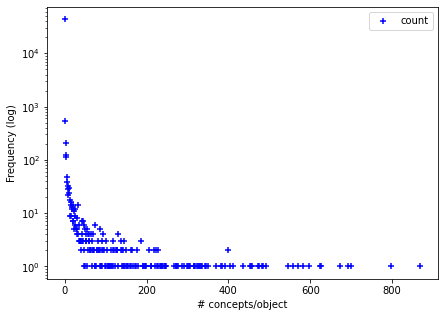

In [86]:
# Distrib plot: number of interesting concepts / object
counts_1 = Counter(big_concept_object[useful_concepts].T.dot(np.ones(len(useful_concepts))))

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plot_distrib(counts_1, ax, log=False, xlabel='# concepts/object', label='count')

print(f'Ratio of objects without interesting concept explaining them: {counts_1.get(0) / concept_object.shape[1]:.3f}')

Average number of object/concept: 55.257


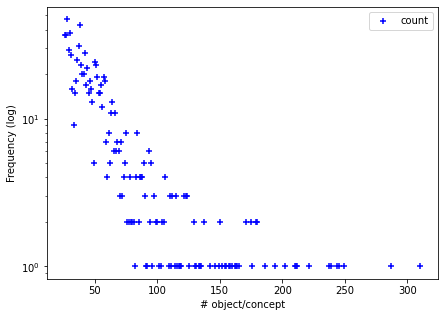

In [87]:
# Distrib plot: number of object per interesting concept 
counts = Counter(big_concept_object[useful_concepts].dot(np.ones(big_concept_object.shape[1])))

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plot_distrib(counts, ax, log=False, xlabel='# object/concept', label='count')

print(f'Average number of object/concept: {np.mean(big_concept_object[useful_concepts].dot(np.ones(big_concept_object.shape[1]))):.3f}')

**Varying $k$ and verify different ratio evolutions**

In [163]:
x = np.arange(1000, 20000, 500)
ratios_res = []
avg_res = []
cumul_concepts = []
avg_intent_size = []

for k in x:
    # Solver for k
    prob = solver(square_dists, concept_attribute, k, msg=False)
    useful_concepts = np.array([int(v.name.split('_')[1]) for v in prob.variables() if v.varValue > 0])
    
    # Count metrics
    counts_concept_per_object = Counter(big_concept_object[useful_concepts].T.dot(np.ones(len(useful_concepts))))    
    counts_object_per_concept = np.mean(big_concept_object[useful_concepts].dot(np.ones(big_concept_object.shape[1])))
    ratio = counts_concept_per_object.get(0) / concept_object.shape[1]
    ratios_res.append(ratio)
    avg_res.append(counts_object_per_concept)
    
    # store cumulated concepts at k
    cumul_concepts.append(tuple(useful_concepts))
    
    # Average size of intent at step k
    avg_intent_size.append(np.sum(concept_attribute[useful_concepts].dot(np.ones(concept_attribute.shape[1]))) / concept_attribute.shape[0])

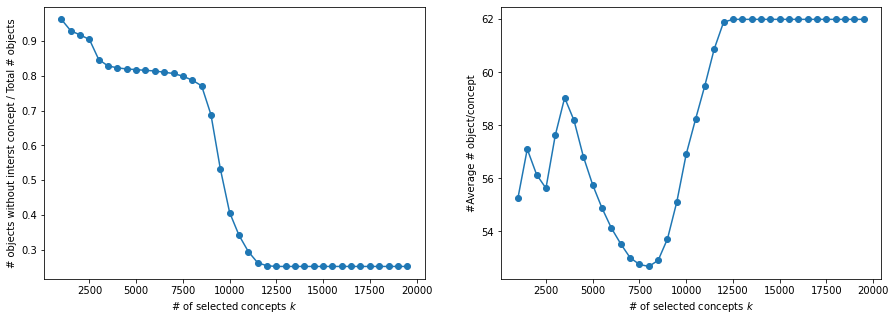

In [195]:
"""ax[2].plot(x, avg_intent_size, label='avg intent size', marker='o')
ax[2].set_xlabel('# of selected concepts $k$')
ax[2].set_ylabel('#Average intent size');"""

# Plot ratio of objects without interesting concept explaining them according to value of k
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(x, ratios_res, label='ratio', marker='o')
ax[0].set_xlabel('# of selected concepts $k$')
ax[0].set_ylabel('# objects without interst concept / Total # objects')
ax[1].plot(x, avg_res, label='avg', marker='o')
ax[1].set_xlabel('# of selected concepts $k$')
ax[1].set_ylabel('#Average # object/concept');


Let's have a look at the concepts that, when included, make the ratio of concept/object drop.

In [175]:
x[18], x[15]

(10000, 8500)

In [192]:
end_concepts = set(cumul_concepts[18])
start_concepts = set(cumul_concepts[15])

diff_concepts = end_concepts.difference(start_concepts)

max_idxs = top_k(concept_object[list(diff_concepts)].dot(np.ones(concept_object.shape[1])), 10)
freqs = concept_object[list(diff_concepts)].dot(np.ones(concept_object.shape[1]))[max_idxs]
print('Concept | # of objects depending on concept')
for i, f in zip(concept_attribute[list(diff_concepts)][max_idxs], freqs):
    print(names_attribute[i.indices], f)    

Concept | # of objects depending on concept
['middle'] 990.0
['suggest'] 944.0
['directly'] 960.0
['connect'] 986.0
['kingdom'] 911.0
['drama'] 893.0
['Association'] 908.0
['dominate'] 881.0
['League'] 847.0
['rich'] 812.0


**Qualitative analysis of results**

In [196]:
k = 9000

prob = solver(square_dists, concept_attribute, k, msg=False)
useful_concepts = np.array([int(v.name.split('_')[1]) for v in prob.variables() if v.varValue > 0])

In [228]:
# an object and its concepts
i = np.random.choice(big_concept_object.shape[1])
#i = 34069
print(names[i], i)
print()
print('New method')
concepts = np.flatnonzero(big_concept_object[useful_concepts][:, i].toarray().ravel() * (length_concept[useful_concepts] >= 1))
#if len(concepts) > 10:
#    concepts = np.random.choice(concepts, size=20, replace=False)
for j in concepts:
    print(names_attribute[big_concept_attribute[useful_concepts][j].indices], j)
    
print()
print(f'old method')
concepts = np.flatnonzero(concept_object[:, i].toarray().ravel() * (length_concept > 1))

for j in concepts:
    print(names_attribute[concept_attribute[j].indices], concept_freq[j], j)

Manu Ginóbili 25875

New method
['gold' 'olympic'] 2182
['gold' 'medal'] 2184
['gold' 'championship'] 2187
['olympic' 'champion'] 2459
['olympic' 'medal'] 2461
['olympic' 'championship'] 2463
['champion' 'medal'] 2486
['champion' 'championship'] 2488
['medal' 'championship'] 2501
['overall' 'gold' 'medal'] 3739
['gold' 'olympic' 'champion'] 4123
['gold' 'olympic' 'medal'] 4125
['gold' 'olympic' 'championship'] 4128
['gold' 'champion' 'medal'] 4130
['gold' 'medal' 'championship'] 4135
['olympic' 'champion' 'medal'] 4539
['olympic' 'medal' 'championship'] 4542
['overall' 'gold' 'olympic' 'medal'] 6956
['Year' 'gold' 'olympic' 'medal'] 7265
['gold' 'olympic' 'champion' 'medal'] 7306
['gold' 'olympic' 'medal' 'championship'] 7313

old method
['club' 'League'] 171 24388
['League' 'Year'] 97 24624
['League' 'All'] 100 24625
['League' 'champion'] 87 24638
['League' 'championship'] 148 24643
['retirement' 'announce'] 100 24724
['Spanish' 'San'] 105 25240
['All' 'Star'] 118 25821
['gold' 'olymp

In [365]:
# Number of objects explained by 1 ore more concepts
len(np.flatnonzero(big_concept_object[useful_concepts].T.dot(np.ones(1000))))

2304

In [379]:
objects_idx_with_concepts = np.flatnonzero(big_concept_object[useful_concepts].T.dot(np.ones(1000)))
i = np.random.choice(objects_idx_with_concepts)

print(names[i], i)
print()
print('New method')
concepts = np.flatnonzero(big_concept_object[useful_concepts][:, i].toarray().ravel() * (length_concept[useful_concepts] >= 1))
#if len(concepts) > 10:
#    concepts = np.random.choice(concepts, size=20, replace=False)
for j in concepts:
    print(names_attribute[big_concept_attribute[useful_concepts][j].indices], j)
    
print()
print(f'old method')
concepts = np.flatnonzero(concept_object[:, i].toarray().ravel() * (length_concept > 1))

for j in concepts:
    print(names_attribute[concept_attribute[j].indices], concept_freq[j], j)

Eric Heiden 12682

New method
['Olympic' 'Games' 'athlete'] 237
['Olympic' 'Games'] 622
['Olympic' 'athlete'] 623
['Games' 'athlete'] 919

old method
['Olympics' 'Olympic'] 180 24330
['Olympics' 'Games'] 177 24331
['Olympics' 'gold'] 223 24333
['Olympics' 'athlete'] 141 24336
['Olympics' 'olympic'] 208 24337
['Olympics' 'medal'] 250 24340
['Olympics' 'Winter'] 119 24341
['Olympics' 'competition'] 112 24344
['Olympic' 'Games'] 244 24928
['Olympic' 'gold'] 147 24929
['Olympic' 'athlete'] 124 24930
['Olympic' 'olympic'] 157 24931
['Olympic' 'medal'] 159 24934
['Olympic' 'competition'] 102 24936
['Games' 'gold'] 136 25196
['Games' 'athlete'] 106 25197
['Games' 'olympic'] 134 25198
['Games' 'medal'] 152 25200
['Games' 'competition'] 103 25202
['gold' 'athlete'] 115 25921
['gold' 'olympic'] 232 25922
['gold' 'medal'] 316 25924
['speed' 'distance'] 111 26409
['athlete' 'olympic'] 149 26438
['athlete' 'medal'] 136 26440
['athlete' 'competition'] 85 26442
['olympic' 'medal'] 248 26669
['olympic